# Machine Design Project

This is a jupyter notebook outlining the design process (up to bearing selection)


In [1]:
import numpy as np

def show(*vars, format_spec = ".3f"):
    for var in vars:
        name = [k for k, v in globals().items() if v is var]
        if name:
            if isinstance(var, tuple) or isinstance(var, list):
                formatted_list = [f'{item:{format_spec}}' for item in var]
                print(f'{name[0]} = {formatted_list}')
            else:
                print(f'{name[0]} = {var:{format_spec}}')
        else:
            print('Variable not found')



## Power Transmission

Assumptions:

- The input gear is reffered to as _Gear 2_, and the output gear is reffered to as _Gear 3_

Knowns:

- One-stage gear reduction
- Input power of 9.5 HP
- Input speed of 3000 rpm
- Output speed of 400 $\pm$ 1% rpm
- Helical gears with helix angle $\psi = 30\degree$ and a normal pressure angle $\phi_n = 20\degree$

Find:

- Gear ratio
- Number of teeth on each gear
- Actual speed of each gear and shaft
- Torque on each gear and shaft

### Analysis

The range of acceptable output speeds is 400 $\pm$ 1%, calculating this range:

In [2]:
input_speed = 3000
output_speed = 400

output_speed_range = (output_speed - output_speed*0.01, output_speed + output_speed*0.01)

show(output_speed_range)

output_speed_range = ['396.000', '404.000']


We can find the speed ratio $e$ using the input and output speeds with equation 18-2.

$$ e = \frac{\omega_3}{\omega_2} \tag{18-2} $$

In [3]:
e = output_speed/input_speed

show(e)

e = 0.133


Using $e$ we can calculate the minimum number of teeth in the pinion $N$ using Equation 13-22. This equation requires the gear ratio $m$, which is equal to $\frac{1}{e}$:

$$
N_P = \dfrac{2k \cos\psi}{(1 + 2m)\sin^2\phi_t}\left( m + \sqrt{m^2 + (1+2m)\sin^2\phi_t} \right) \tag{13-22}
$$

In this equation, $k = 1$ for full-depth teeth, and $\phi_t$ can be calculated using $\tan\phi_t = \frac{\tan\phi_n}{\cos\psi}$.


In [4]:
def helical_NP_equation(m, psi, phi_t, k=1):
    
    return ((2*k*np.cos(psi)) / ((1 + 2*m) * np.sin(phi_t)**2)) * (m + np.sqrt(m**2 + (1 + 2*m)*np.sin(phi_t)**2))

m = 1/e

psi = np.deg2rad(30)
phi_n = np.deg2rad(20)
phi_t = np.arctan(np.tan(phi_n)/np.cos(psi))

N_P = helical_NP_equation(m, psi, phi_t)

show(N_P)

N_P = 10.931


We round this value of $N_P$ up to the nearest integer number of teeth, and then multiply $N_P$ by the gear ratio to obtain the number of teeth in the gear $N_G$, which we then round down to the nearest integer. If the ratio between these integer number of teeth is results in an output speed within tolerance then we have found the number of needed teeth.

In [5]:
from math import ceil, floor

N_2 = ceil(N_P)
show(N_2)

N_G = m*N_2
show(N_G)

N_3 = floor(N_G)
show(N_3)

# Finding the actual speed ratio (inverse of actual gear ratio)
e_actual = N_2/N_3

output_speed_actual = e_actual * input_speed
show(e_actual, output_speed_actual)

print(f'Actual output in tolerance?: {output_speed_range[0] <= output_speed_actual <= output_speed_range[1]}')

N_2 = 11.000
N_G = 82.500
N_3 = 82.000
e_actual = 0.134
output_speed_actual = 402.439
Actual output in tolerance?: True


With the actual input and output speeds determined along with the gear tooth counts, we can calculate the torque applied to each shaft/gear.

$$
T = \frac{H}{\omega} \cdot 550\frac{\text{ft-lbf/s}}{\text{hp}} \cdot \frac{1 \text{rev}}{2\pi \text{rad}} \cdot 60\frac{\text{s}}{\text{min}} \cdot 12\frac{\text{in}}{\text{ft}}
$$

$$
\rightarrow T \text{(lbf in)} = \dfrac{396000 H}{2\pi \omega}
$$

In [6]:
from numpy import pi

H = 9.5

T_2 = (396000 * H)/(2*pi * input_speed)
T_3 = (396000 * H)/(2*pi * output_speed_actual)

show(T_2, T_3)

T_2 = 199.580
T_3 = 1487.780


## Gear Selection

Assumptions:

- Gear and pinion are made of the same material
- The quality number of the gears is $Q_v = 7$
- The overload factor is $K_o = 1$

Knowns:

- Maximum width of 15 inches with 1.5 inches for wall thickness and clearance.
- Pinion and gear to operate for 1000 hours at 90% reliability
- Commercial enclosed unit
- Uncrowned teeth
- Not adjusted at assembly or lapped
- Use $K_s = 1$ and $C_f = 1$
- Light shock load from engine and moderate shock load from wheels
- Safety factors against bending and wear are to be $S_F = S_H = 1.2$

Find:

- Diametral pitch of the gears
- Gear and pinion material
- Actual safety factors of material selection for gear and pinion

### Analysis

The first step is to find the diametral pitches $P$ of the gears. The minimum diametral pitch is constrained by the maximum size of the gearbox, $Y = 15$ in, and allotted space for clearances and wall thickness, $X = 1.5$ in. The total width $Y$ is:

$$ Y = d_2 + d_3 + 2/P + X $$

Where $2/P$ accounts for the addendums of the gear and pinion. We can substitute $d_i = N_i/P$ to get:

$$ Y = N_2/P + N_3/P + 2/P + X $$

$$ P_t = \dfrac{N_2 + N_3 + 2}{Y - X} $$

In [7]:
max_gearbox_width = 15
clearances = 1.5
P_t = (N_2 + N_3 + 2)/(max_gearbox_width - clearances)

show(P_t)

# Finding the normal pitch
P_n = P_t/np.cos(psi)
show(P_n)

P_t = 7.037
P_n = 8.126


This gives us a minimum for $P$. __Table 13-2__ lists common values of $P_n$ (which is why $P_n$ was calculated before), we round up to the nearest value where we find...

In [8]:
P_n = 10 #teeth/inch
P_t = P_n * np.cos(psi)
show(P_t)

d_2 = N_2/P_t   # Lecture 27 slide 8
d_3 = N_3/P_t
show(d_2, d_3)

P_t = 8.660
d_2 = 1.270
d_3 = 9.469


In [9]:
Y = d_2 + d_3 + clearances + (2/P_t)
show(Y)

Y = 12.470



Next, we need to find the required strength of materials for both the pinion and gear, for both wear and bending, ie, $S_{tG}$, $S_{CG}$, $S_{tP}$, and $S_{CP}$. These can be found using the AGMA equations.

$$
\sigma = W^t K_o K_v K_s \dfrac{P_d}{F} \dfrac{K_m K_B}{J}
$$

$$
S_F = \dfrac{S_t Y_N / (K_T K_R)}{\sigma} \rightarrow S_t = \sigma\dfrac{S_F K_T K_R}{Y_N}
$$

$$
\sigma_C = C_p \sqrt{W^t K_o K_v K_s \frac{K_m}{d_p F} \frac{C_f}{I}}
$$

$$
S_H = \dfrac{S_C Z_N C_H / (K_T K_R)}{\sigma_C} \rightarrow S_C = \sigma_C\dfrac{S_H K_T K_R}{Z_N C_H}
$$

To start finding these, we begin by finding general terms for the gear and pinion: $V$, $W^t$, and $F$. 

In [10]:
# Finding pitch-line velocity from Equation 13-34
V = (pi * d_2 * input_speed)/12

show(V)

# Transmitted load via Equation 13-35
W_t = 33000 * (H/V)

show(W_t)

V = 997.590
W_t = 314.257


In [11]:
# F is typically 3 to 5 times the circular pitch. Assuming F is 4 times the pitch (via textbook). 

F = 4 * (pi / P_t)

show(F)

F = 1.451


In [12]:
# Assignment specifies that face widths are available in 0.25 inch increments, rounding to the closest face width we get:

F = 1.50

Now we just need to find the AGMA stuff. I'm going to do the factors that are the same between gear and pinion first.

In [13]:
# From assumptions and assignment description:
K_s = C_f = 1

# Light shock load and medium tire shock (Figure 14-17)
K_o = 1.50

In [29]:
from numpy import sqrt
# Calculating K_v
Q = 5

B = 0.25 * (12 - Q)**(2/3)
A = 50 + 56*(1 - B)

K_v = ((A + sqrt(V))/A)**B
show(K_v)

# Checking that V is within maximum pitch-line velocity
V_max = (A + (Q - 3))**2
show(V_max)
show(V)

K_v = 1.517
V_max = 3222.801
V = 997.590


We are below the maximum pitch-line velocity, so we don't need to change our $Q$.

In [15]:
# K_m calculation

C_mc = 1    # uncrowned
C_pf = (F/(10*d_2)) - 0.0375 + 0.0125*F #14-32
C_pm = 1    # Evenly spaced between bearings

A = 0.127
B = 0.0158
C = -0.930e-4
C_ma = A + B*F + C*F**2     # Commerical enclosed

C_e = 1     # Not adjusted or lapped

K_m = 1 + C_mc*(C_pf*C_pm + C_ma*C_e)

show(K_m)

K_m = 1.250


We can just assume $K_B = 1$ since we're not adjusting the rim thickness. Same with the temperature factor $K_T$, we're not accounting for higher temperatures.

In [16]:
K_B = K_T = 1

In [17]:
# Reliability calculation for K_R at 90% reliability
K_R = 0.85  # Table 14-10

The elastic coefficient $C_p$ depends on the materials selected for the gear and pinion, so we'll just assume that we're going to select a steel material for both gears, which results in:

In [18]:
C_p = 2300 # Table 14-8

The hardness ratio coefficient $C_H$ can be set equal to 1 because we're assuming the same material for both gear and pinion

In [19]:
C_H = 1

That's all of the coefficients that are the same between both gears. Now the different ones.

For the stress-cycle factors ($Y_N$ and $Z_N$) we first have to convert the desired life of the gears in hours to a desired life in revolutions, which is dependent on the speed of the gear:

$$ L_{rev,i} = L_{hours} \cdot 60\frac{\text{min}}{\text{h}} \cdot \omega_i $$

In [20]:
L_hours = 1000

L_2 = L_hours * 60 * input_speed
L_3 = L_hours * 60 * output_speed_actual

show(L_2, L_3, format_spec=".3e")

L_2 = 1.800e+08
L_3 = 2.415e+07


With these found we can use __Figure 14-14__ to find $Y_N$ and __14-15__ for $Z_N$

In [21]:
Y_N2 = 1.6831 * L_2**(-0.0323)
Z_N2 = 2.466 * L_2**(-0.056)

Y_N3 = 1.6831 * L_3**(-0.0323)
Z_N3 = 2.466 * L_3**(-0.056)

show(Y_N2, Z_N2, Y_N3, Z_N3)

Y_N2 = 0.911
Z_N2 = 0.851
Y_N3 = 0.972
Z_N3 = 0.952


Geometry $J$ factor. The "Further Guidance for the Project" file provides details on how to find $J$, so I'm going to follow those guidelines:

In [22]:
show(N_2, N_3)

N_2 = 11.000
N_3 = 82.000


In [30]:
# From figures 14-7 and 14-8:

# Pinion has 11 teeth meshing with 82 teeth on gear, using 20 tooth line on 14-7 and 75-tooth line on 14-8
J_prime_2 = 0.465
J_2 = J_prime_2 * 1.00

# Gear has 82 teeth meshing with 11 teeth on pinion, thus using 60 tooth line on 14-7 and 20 tooth line on 14-8
J_prime_3 = 0.54
J_3 = J_prime_3 * 0.945

show(J_2, J_3)

J_2 = 0.465
J_3 = 0.510


Surface strength geometry factor $I$. These use equations 14-21 through 14-26

In [31]:
# Get pitch radii
r_2 = d_2/2
r_3 = d_3/2

# Base circle pitch-radii (Eq 14-26)
rb_2 = r_2*np.cos(phi_t)
rb_3 = r_3*np.cos(phi_t)

# Addendum
a = 1/P_n

# Equation 14-25
Z = sqrt((r_2 + a)**2 - rb_2**2) + sqrt((r_3 + a)**2 - rb_3**2) - (r_2 + r_3)*np.sin(phi_t)

# Speed ratio (Eq 14-22)
m_G = N_3/N_2

# Equation 14-24
p_n = pi/P_n
p_N = p_n * np.cos(phi_n)

# Equation 14-21
m_N = p_N/(0.95 * Z)

# Equation 14-23 (External gears)
I = ((np.cos(phi_t) * np.sin(phi_t))/(2 * m_N)) * ((m_G)/(m_G + 1))

show(rb_2, rb_3, a, Z, m_N, I)

rb_2 = 0.585
rb_3 = 4.364
a = 0.100
Z = 0.443
m_N = 0.702
I = 0.224


That should be all of them, we can now calculate the required strengths for the pinion and gear in wear and bending using safety factors of 1.2.

In [32]:
S_F = S_H = 1.2

# Pinion calculations

sigma_2 = W_t * K_o * K_v * K_s * (P_t/F) * ((K_m * K_B)/J_2)
St_2 = sigma_2 * ((S_F * K_T * K_R)/Y_N2)

sigma_C2 = C_p * sqrt(W_t * K_o * K_v * K_s * (K_m/(d_2*F)) * (C_f/I))
SC_2 = sigma_C2 * ((S_H*K_T*K_R)/(Z_N2 * C_H))

show(St_2, SC_2, format_spec='.3e')

St_2 = 1.242e+04
SC_2 = 1.261e+05


In [33]:
# Gear calculations

sigma_3 = W_t * K_o * K_v * K_s * (P_t/F) * ((K_m * K_B)/J_3)
St_3 = sigma_3 * ((S_F * K_T * K_R)/Y_N3)

sigma_C3 = C_p * sqrt(W_t * K_o * K_v * K_s * (K_m/(d_3*F)) * (C_f/I))
SC_3 = sigma_C3 * ((S_H*K_T*K_R)/(Z_N3 * C_H))

show(St_3, SC_3, format_spec='.3e')

St_3 = 1.061e+04
SC_3 = 4.127e+04


The largest required strength is for the pinion, with $S_{C,req} = 98.9$ ksi and $S_{t,req} = 9.89$ ksi, so those strengths are what we'll look for in table __14-3__ and __14-6__. From these tables we choose Grade 1 Flame-hardened steel with $S_C = 170$ ksi and $S_t = 45$ ksi. This material works for both the gear and pinion.

We now need to find the acheived factors of safety.

In [34]:
S_t = 45e3
S_C = 170e3

# Using equation 14-17/18 with S_H = S_F = 1
S_H = S_F = 1

sigma_all2 = (S_t * Y_N2)/(S_F * K_T * K_R)
sigma_Call2 = (S_C * Z_N2 * C_H)/(S_H * K_T * K_R)

n_2 = sigma_all2/sigma_2
n_C2 = sigma_Call2/sigma_C2

show(n_2,  n_C2)

n_2 = 4.347
n_C2 = 1.618


In [35]:
sigma_all3 = (S_t * Y_N3)/(S_F * K_T * K_R)
sigma_Call3 = (S_C * Z_N3 * C_H)/(S_H * K_T * K_R)

n_3 = sigma_all3/sigma_3
n_C3 = sigma_Call3/sigma_C3

show(n_3, n_C3)

n_3 = 5.090
n_C3 = 4.944


## Force Analysis
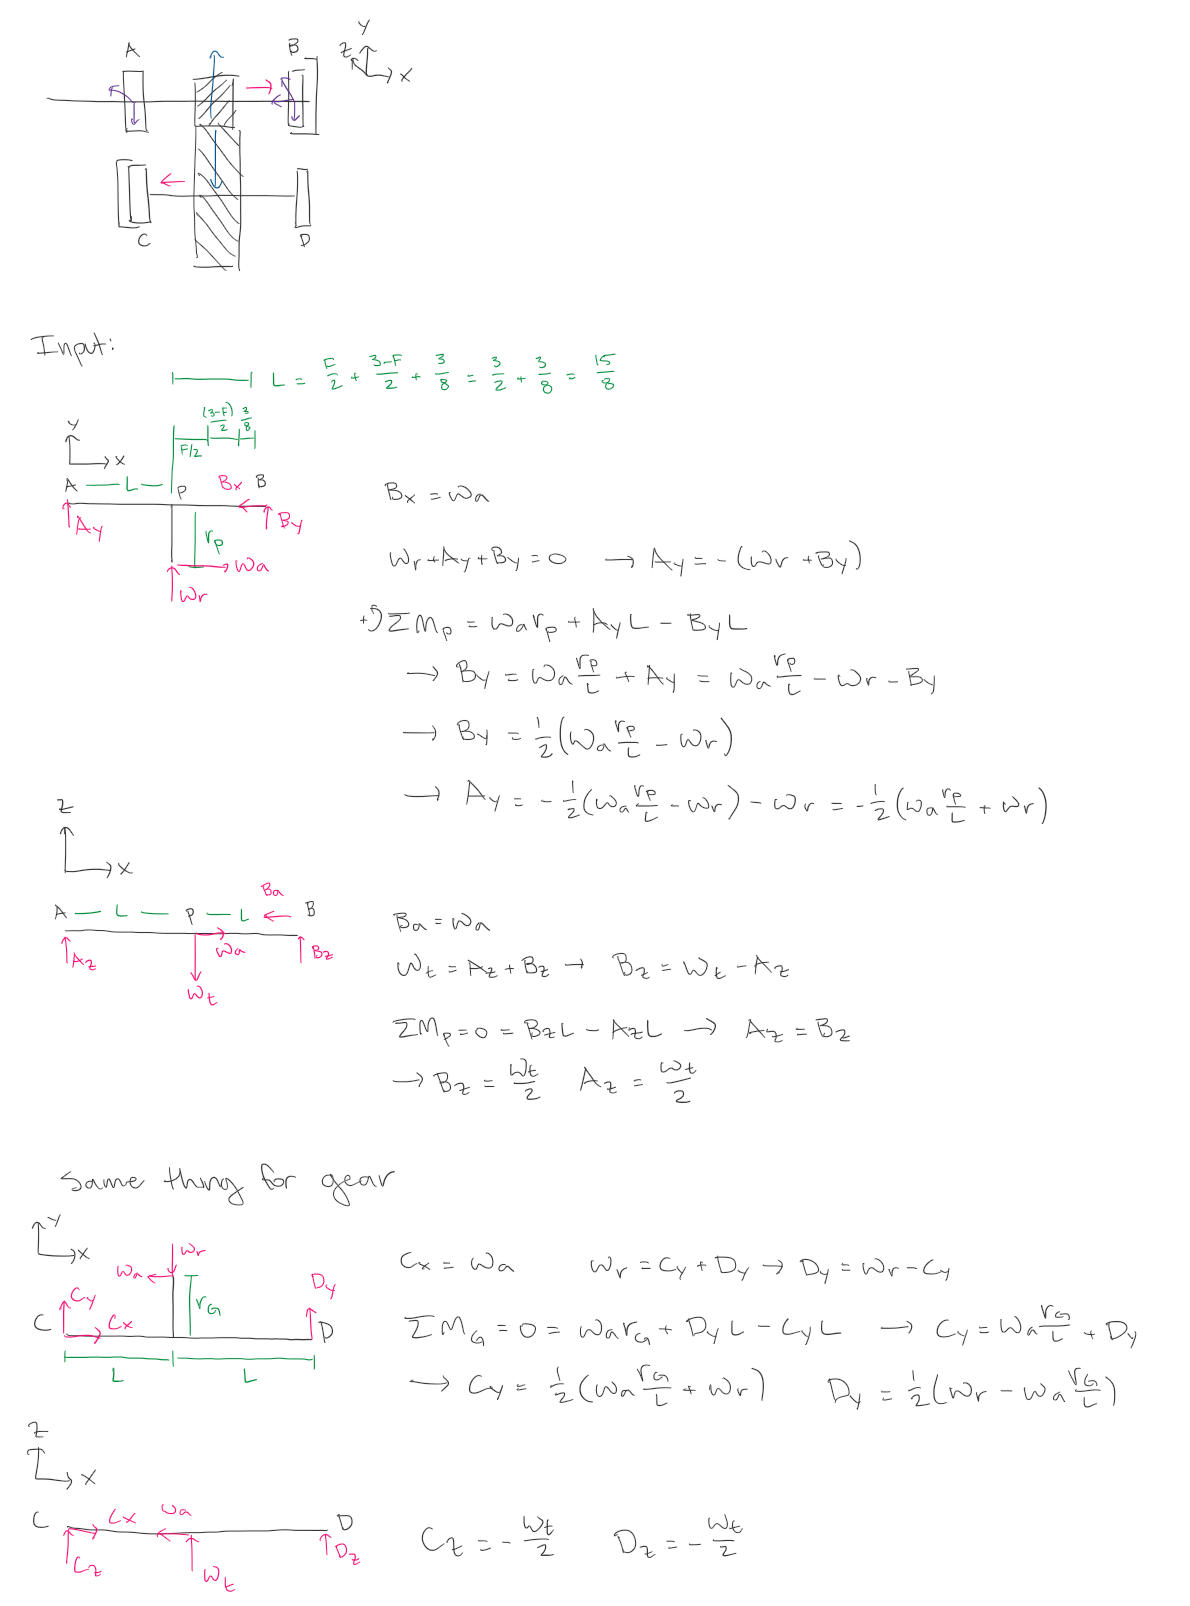

We need to find $W_t$, $W_r$, and $W_a$ for each gear.